# Hide the box around graphs

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.style.use({'axes.spines.top': False, 'axes.spines.right': False})

# Bar Graphs

Here is a sample [bar graph](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.bar) in matplotlib

We'll start by creating some mock data

In [2]:
xvalues = np.arange(4) + 0.5
data = np.arange(1, 5)
lower = np.zeros(4)
upper = 0.5*np.ones(4)
sem = [lower, upper]
labels = ['A', 'B', 'C', 'D']
edges = ['k']*4

And now the plot. Note that there are only upper bounds on the error bars because zeros were passed for the lower values by defining sem as a list with two sets of values.

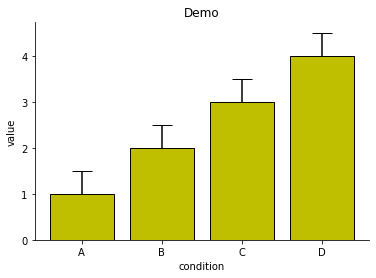

In [3]:
plt.bar(xvalues, data, yerr=sem, tick_label=labels,
        color='y', edgecolor=edges, capsize=10)
plt.xlabel('condition')
plt.ylabel('value')
plt.title('Demo');

# Multibar graphs

Here is a function that returns a multi bar graph

In [4]:
def multi_bar_plot(data, labels=None, errors=None, capsize=20):
    ''' make a multiple bar plot

    data: list of values
    labels: list of x_axis labels
    err: list of values for error bars

    '''
    fig = plt.figure()
    bars = len(data)
    width = 1/(bars + 1)
    x = np.arange(len(data[0])) - width*(bars-1)/2
    if labels is None:
        labels = np.arange(len(data[0]))

    if errors is None:
        for heights in data:
            plt.bar(x, heights, width=width)
            x += width
    else:
        for heights, err in zip(data, errors):
            plt.bar(x, heights, width=width, yerr=err, capsize=capsize/bars)
            x += width

    if labels is not None:
        plt.xticks(np.arange(len(data[0])), labels)
    else:
        plt.xticks(np.arange(len(data[0])))

    return fig

And some data to test it ....

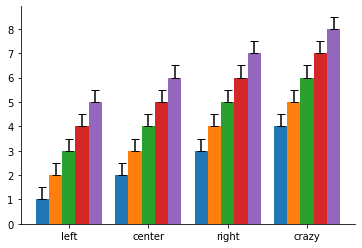

In [5]:
data1 = np.arange(4) + 1
data2 = data1 + 1
data3 = data2 + 1
data4 = data3 + 1
data5 = data4 + 1
data = [data1, data2, data3, data4, data5]
error1 = np.asarray([0.5]*len(data1))
error0 = np.zeros_like(data1)
temp = [error0, error1]
err = [temp]*len(data)
labels = ['left', 'center', 'right', 'crazy']
fig = multi_bar_plot(data, labels, err);

# Bar graphs with Pandas

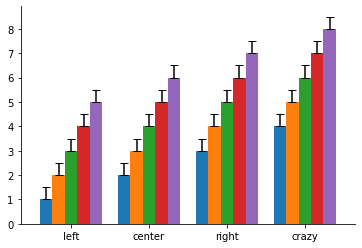

In [6]:
import pandas as pd
df = pd.DataFrame({'data1': data1, 'data2': data2, 'data3': data3, 'data4': data4, 'data5': data5},
                 index=labels)

df.plot.bar(rot=0, legend=False, width=0.8, yerr=err, capsize=4)

# Bar graphs with Seaborn
We need to [convert](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.wide_to_long.html) wide format data to long format (tidy) to work well with Seaborn. If we included all of the data, Seaborn would calculate error bars for us.

In [7]:
import seaborn as sns

df2 = pd.wide_to_long(df.reset_index(), ['data'], i='index', j='dataset').reset_index()
df2.rename(columns={'index': 'position'}, inplace=True)
df2.head()

position  dataset  data
0     left        1     1
1   center        1     2
2    right        1     3
3    crazy        1     4
4     left        2     2

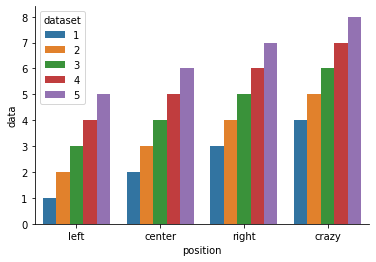

In [8]:
sns.barplot(x='position', y='data', hue='dataset', data=df2)

# Bar Graphs with Plotnine

[Plotnine](https://plotnine.readthedocs.io/en/stable/) is a python implementation of [ggplot2](https://ggplot2.tidyverse.org/) from [R](https://www.r-project.org/)

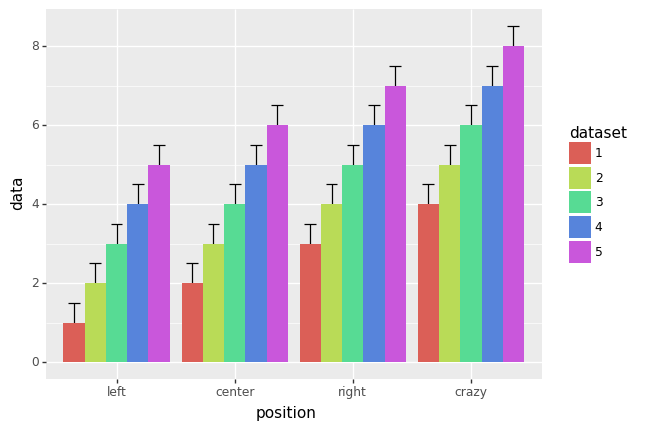

<ggplot: (9278552)>

In [9]:
from plotnine import *

df2.dataset = df2.dataset.astype("category") # plotnine needs this to be categorical
categories = ['left', 'center', 'right', 'crazy']
position_cat = pd.Categorical(df2['position'], categories=categories) # This goofiness is because Plotnine will plot categories alphabetically
df2['position'] = position_cat                                        # unless we specify the order
ymin = df2.data.values - 0.5
ymax = ymin + 1
(ggplot(df2, aes(x='position', y='data', fill='dataset'))
+ geom_errorbar(aes(ymin=ymin, ymax=ymax), position=position_dodge(0.9))
+ geom_col(position='dodge')) # hide lower error bars by drawing error bars first and then drawing bars

# Bar Graphs with Altair

[Altair](https://altair-viz.github.io/) is a declarative statistical visualization library based on [Vega-Lite](http://vega.github.io/vega-lite/), a "grammar" of interactive graphics for web display.

In [10]:
import altair as alt

df2['ymin'] = ymin
df2['ymax'] = ymax

bars = alt.Chart().mark_bar().encode(
    x=alt.X('dataset', title='', axis=None),
    y='data', 
    color='dataset',
)

errors = alt.Chart().mark_errorbar().encode(x='dataset',
    y=alt.Y('ymin', title='data'), y2='ymax')      # need to rename y axis to data from default of ymin

alt.layer(errors, bars, data=df2).facet(           # Drawing the error bars first hides the lower part
    column=alt.Column('position', sort=categories, # Altair also sorts alphabetically by default
        header=alt.Header(labelOrient='bottom', titleOrient='bottom'))).configure_axis(grid=False).configure_view(strokeOpacity=0)

alt.FacetChart(...)